# Homework 2.2: The Quest For A Better Network

In this assignment you will build a monster network to solve Tiny ImageNet image classification.

This notebook is intended as a sequel to seminar 3, please give it a try if you haven't done so yet.

(please read it at least diagonally)

* The ultimate quest is to create a network that has as high __accuracy__ as you can push it.
* There is a __mini-report__ at the end that you will have to fill in. We recommend reading it first and filling it while you iterate.
 
## Grading
* starting at zero points
* +20% for describing your iteration path in a report below.
* +20% for building a network that gets above 20% accuracy
* +10% for beating each of these milestones on __TEST__ dataset:
    * 25% (50% points)
    * 30% (60% points)
    * 32.5% (70% points)
    * 35% (80% points)
    * 37.5% (90% points)
    * 40% (full points)
    
## Restrictions
* Please do NOT use pre-trained networks for this assignment until you reach 40%.
 * In other words, base milestones must be beaten without pre-trained nets (and such net must be present in the anytask atttachments). After that, you can use whatever you want.
* you __can't__ do anything with validation data apart from running the evaluation procedure. Please, split train images on train and validation parts

## Tips on what can be done:


 * __Network size__
   * MOAR neurons, 
   * MOAR layers, ([torch.nn docs](http://pytorch.org/docs/master/nn.html))

   * Nonlinearities in the hidden layers
     * tanh, relu, leaky relu, etc
   * Larger networks may take more epochs to train, so don't discard your net just because it could didn't beat the baseline in 5 epochs.

   * Ph'nglui mglw'nafh Cthulhu R'lyeh wgah'nagl fhtagn!


### The main rule of prototyping: one change at a time
   * By now you probably have several ideas on what to change. By all means, try them out! But there's a catch: __never test several new things at once__.


### Optimization
   * Training for 100 epochs regardless of anything is probably a bad idea.
   * Some networks converge over 5 epochs, others - over 500.
   * Way to go: stop when validation score is 10 iterations past maximum
   * You should certainly use adaptive optimizers
     * rmsprop, nesterov_momentum, adam, adagrad and so on.
     * Converge faster and sometimes reach better optima
     * It might make sense to tweak learning rate/momentum, other learning parameters, batch size and number of epochs
   * __BatchNormalization__ (nn.BatchNorm2d) for the win!
     * Sometimes more batch normalization is better.
   * __Regularize__ to prevent overfitting
     * Add some L2 weight norm to the loss function, PyTorch will do the rest
       * Can be done manually or like [this](https://discuss.pytorch.org/t/simple-l2-regularization/139/2).
     * Dropout (`nn.Dropout`) - to prevent overfitting
       * Don't overdo it. Check if it actually makes your network better
   
### Convolution architectures
   * This task __can__ be solved by a sequence of convolutions and poolings with batch_norm and ReLU seasoning, but you shouldn't necessarily stop there.
   * [Inception family](https://hacktilldawn.com/2016/09/25/inception-modules-explained-and-implemented/), [ResNet family](https://towardsdatascience.com/an-overview-of-resnet-and-its-variants-5281e2f56035?gi=9018057983ca), [Densely-connected convolutions (exotic)](https://arxiv.org/abs/1608.06993), [Capsule networks (exotic)](https://arxiv.org/abs/1710.09829)
   * Please do try a few simple architectures before you go for resnet-152.
   * Warning! Training convolutional networks can take long without GPU. That's okay.
     * If you are CPU-only, we still recomment that you try a simple convolutional architecture
     * a perfect option is if you can set it up to run at nighttime and check it up at the morning.
     * Make reasonable layer size estimates. A 128-neuron first convolution is likely an overkill.
     * __To reduce computation__ time by a factor in exchange for some accuracy drop, try using __stride__ parameter. A stride=2 convolution should take roughly 1/4 of the default (stride=1) one.
 
   
### Data augmemntation
   * getting 5x as large dataset for free is a great 
     * Zoom-in+slice = move
     * Rotate+zoom(to remove black stripes)
     * Add Noize (gaussian or bernoulli)
   * Simple way to do that (if you have PIL/Image): 
     * ```from scipy.misc import imrotate,imresize```
     * and a few slicing
     * Other cool libraries: cv2, skimake, PIL/Pillow
   * A more advanced way is to use torchvision transforms:
    ```
    transform_train = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])
    trainset = torchvision.datasets.ImageFolder(root=path_to_tiny_imagenet, train=True, download=True, transform=transform_train)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)

    ```
   * Or use this tool from Keras (requires theano/tensorflow): [tutorial](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html), [docs](https://keras.io/preprocessing/image/)
   * Stay realistic. There's usually no point in flipping dogs upside down as that is not the way you usually see them.
   


In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="3"

In [2]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt

from torch import nn as nn
#torch.set_default_tensor_type('torch.cuda.FloatTensor')
torch.manual_seed(42)

from warnings import filterwarnings
filterwarnings('ignore')

%matplotlib inline

So let's load some data...

In [3]:
from tiny_img import download_tinyImg200
data_path = '.'
download_tinyImg200(data_path)

./tiny-imagenet-200.zip


In [4]:
dataset = torchvision.datasets.ImageFolder('tiny-imagenet-200/train', transform=torchvision.transforms.ToTensor())
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [80000, 20000])

In [5]:
labels = sorted(np.unique([data[1] for data in train_dataset]))
n_classes = len(labels)

At this moment I'd already had a spoiler... Thinking of the architecture of the network to build I decided to restrain myself with ResNet family, as I never used a single model from it before. So I read the article provided above and tried some pre-assembled (not pre-trained) models from torchvision as a baseline. It turned out that each of them overfits like hell and it's impossible to approach an appropriate score using them. This fact made me writing my own ResNet-like model in the style of pytorchvision, and I decided to simplify it. What have I done? Basic ResNet consists of four blocks containing sub-blocks of type ResNetBlock. Each of the main blocks becomes shallower than previous, and this chain ends with AvgPooling over the shape of a single image. So I dropped all blocks but the first, which allowed me to get rid of downsampling (each sub-block preserved the shape of an image). I also added dropout at the end of each block in order to deal with overfitting.

In [6]:
class ResBlock(nn.Module):
    def __init__(self, inplanes, planes, kernel_size=3, stride=1, downsample=None):
        super().__init__()
        
        self.kernel_size = kernel_size
        self.stride = stride
        self.downsample = downsample
        
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=kernel_size, padding=kernel_size // 2,
                               stride=stride, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=kernel_size, padding=kernel_size // 2,
                               stride=stride, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.dropout = nn.Dropout(p=0.1, inplace=True)
        
        
    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.dropout(out)

        out += identity
        out = self.relu(out)

        return out


class ResNet(nn.Module):
    def __init__(self, block, n_blocks, n_classes, inplanes=64, planes=64,
                 kenel_size=7, stride=2, zero_init_residual=False):
        super().__init__()
        
        self.inplanes = inplanes
        self.kernel_size = kenel_size
        self.stride = stride
        
        self.conv1 = nn.Conv2d(3, 64, kernel_size=kenel_size, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.relu = nn.ReLU(inplace=True)
        self.blocks = self._add_blocks(block, planes, n_blocks)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(planes, n_classes)
        
        for module in self.modules():
            if isinstance(module, nn.Conv2d):
                nn.init.kaiming_normal_(module.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(module, nn.BatchNorm2d):
                nn.init.constant_(module.weight, 1)
                nn.init.constant_(module.bias, 0)

                
    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.maxpool(out)
        out = self.relu(out)
        out = self.blocks.forward(out)
        out = self.avgpool(out)
        out = out.view(x.size(0), -1)
        out = self.fc(out)

        return out

    
    def _add_blocks(self, block, planes, n_blocks):
        return nn.Sequential(*[block(self.inplanes, planes) for _ in range(n_blocks)])
    
    
def compute_loss(model, X_batch, y_batch, C=0, criterion=nn.L1Loss(size_average=False)):
    logits = model.cuda()(X_batch.cuda())
    
    loss = nn.functional.cross_entropy(logits, y_batch.cuda()).mean()
    
    if C:
        reg_loss = 0
        for param in model.parameters():
            reg_loss += criterion(param, torch.zeros(param.shape).cuda())
        
        loss += C * reg_loss
    
    return logits, loss

Here I constructed my model with 5 sub-blocks in the main block.

In [7]:
model = ResNet(ResBlock, 5, n_classes)

In [8]:
batch_size = 50

train_batch_gen = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=1)
val_batch_gen = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=1)

In [9]:
import numpy as np
from IPython.display import clear_output
from collections import namedtuple

Logger = namedtuple('Logger', ['train_loss_', 'train_accuracy_', 'val_loss_', 'val_accuracy_'])


def get_logger():
    return Logger(*[[] for _ in range(4)])


def compute_accuracy(y_true, y_pred):
    return np.mean((y_true.cpu() == y_pred.cpu()).numpy())


def evaluate_model(model, val_batch_gen, C=0, logs=None):
    if not logs:
        logs = get_logger()
    
    model.train(False)
    for X_batch, y_batch in val_batch_gen:
        logits, loss = compute_loss(model, X_batch, y_batch, C)
        y_pred = logits.max(1)[1].data
        logs.val_loss_.append(loss.cpu().data.numpy())
        logs.val_accuracy_.append(compute_accuracy(y_batch, y_pred))
        
    return logs


def train_model(model, train_batch_gen, val_batch_gen, n_epochs=50, plot_graph=True, C=0, **optimizer_params):
    opt = torch.optim.Adam(model.parameters(), **optimizer_params)
    logs = get_logger()
    
    for epoch in range(n_epochs):
        epoch_logs = get_logger()
        
        model.train(True)
        for X_batch, y_batch in train_batch_gen:
            logits, loss = compute_loss(model, X_batch, y_batch, C)
            y_pred = logits.max(1)[1].data
            loss.backward()
            opt.step()
            opt.zero_grad()
            epoch_logs.train_loss_.append(loss.cpu().data.numpy())
            epoch_logs.train_accuracy_.append(compute_accuracy(y_batch, y_pred))
        
        evaluate_model(model, val_batch_gen, C, epoch_logs)
            
        for attr in dir(epoch_logs):
            if attr.endswith('_') and not attr.endswith('__'):
                getattr(logs, attr).append(np.mean(getattr(epoch_logs, attr)))
    
        if plot_graph:
            clear_output()
            plt.figure(figsize=(15, 5))
            grid = np.arange(1, epoch + 2)
            
            fig = plt.subplot(121)
            fig.set_title('Loss in dependency on number of epochs')
            fig.plot(grid, logs.train_loss_, label='train')
            fig.plot(grid, logs.val_loss_, label='val')
            fig.set_xlabel('epoch')
            fig.set_ylabel('loss')
            fig.grid()
            
            fig = plt.subplot(122)
            fig.set_title('Accuracy in dependency on number of epochs')
            fig.plot(grid, logs.train_accuracy_, label='train')
            fig.plot(grid, logs.val_accuracy_, label='val')
            fig.set_xlabel('epoch')
            fig.set_ylabel('accuracy')
            fig.grid()
            
            plt.show()
            
    return logs

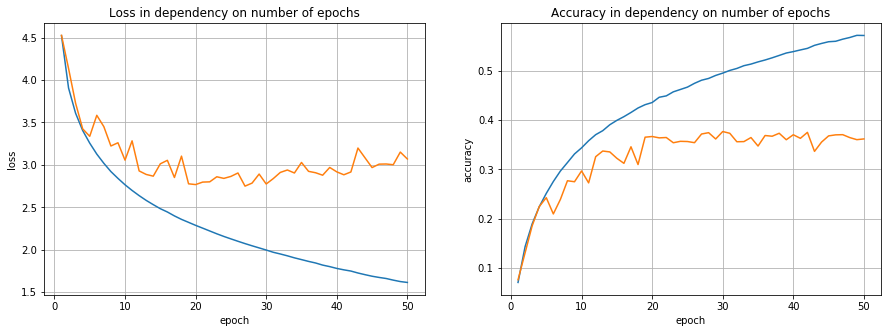

In [10]:
logs = train_model(model, train_batch_gen, val_batch_gen)

It was the time to add some regularization.

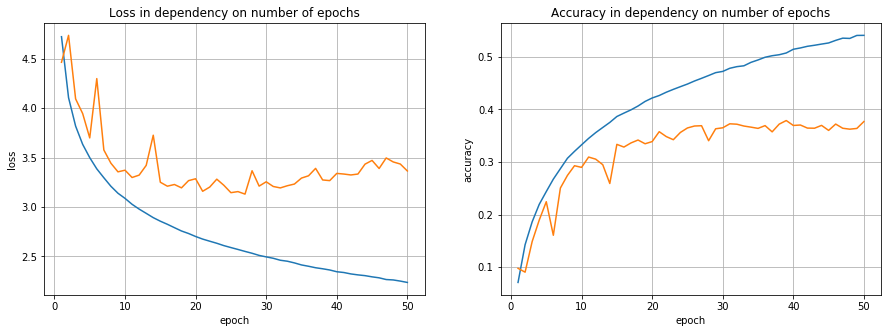

In [11]:
model = ResNet(ResBlock, 5, n_classes)
logs = train_model(model, train_batch_gen, val_batch_gen, C=10e-6)

According to the graphs the model had still overfitted, but the accuracy of its predictions remained stable since a certain iteration. It brang me to the idea of data augmentation so that my complicated model could consume more information and improve its generalization ability.

In [12]:
import torchvision
from torchvision import transforms
from copy import deepcopy

transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

dataset = torchvision.datasets.ImageFolder('tiny-imagenet-200/train/', transform=transform)
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [80000, 20000])

train_batch_gen = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

val_dataset = deepcopy(val_dataset)
val_dataset.dataset.transform = test_transform
val_batch_gen = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

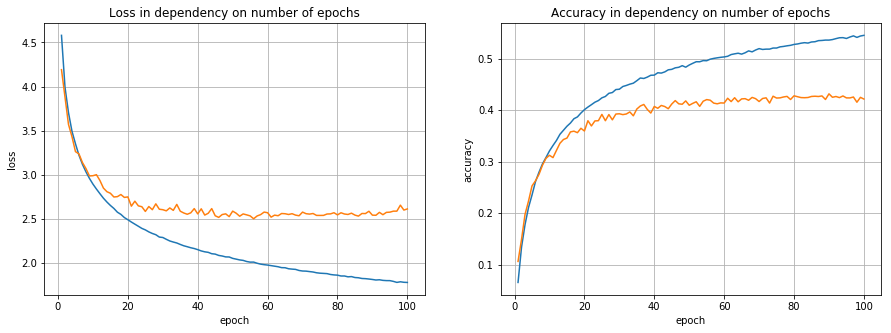

In [13]:
model = ResNet(ResBlock, 5, n_classes)
logs = train_model(model, train_batch_gen, val_batch_gen, n_epochs=100)

When everything is done, please calculate accuracy on `tiny-imagenet-200/val`

In [14]:
import pandas as pd

from skimage.io import imread


class TestLoader(torchvision.datasets.DatasetFolder):
    def __init__(self, root, annotation_file, class_to_label, transform=None):
        self.annotation = pd.read_csv(annotation_file, sep='\t', header=None)
        self.class_to_label = class_to_label
        self.root = root
        self.transform = transform
    
        
    def __len__(self):
        return self.annotation.shape[0]
    

    def __getitem__(self, idx):
        img_path = os.path.join(self.root, self._get_name(idx))
        image = imread(img_path)
        
        if image.ndim != 3:
            image = np.concatenate([image[:, :, np.newaxis] for _ in range(3)], axis=-1)
    
        if self.transform:
            image = self.transform(image)
    
        return image, self.class_to_label[self._get_class(idx)]
    
    
    def _get_class(self, idx):
        return self.annotation.iloc[idx, 1]
    
    
    def _get_name(self, idx):
        return self.annotation.iloc[idx, 0]

In [15]:
test_dataset = TestLoader('tiny-imagenet-200/val/images/','tiny-imagenet-200/val/val_annotations.txt',
                          train_dataset.dataset.class_to_idx, transform=test_transform)
test_batch_gen = torch.utils.data.DataLoader(test_dataset, batch_size=50, shuffle=True, num_workers=1)

In [24]:
test_logs = evaluate_model(model, test_batch_gen)

In [25]:
test_accuracy = np.mean(test_logs.val_accuracy_)

print("Final results:")
print("  test accuracy:\t\t{:.2f} %".format(
    test_accuracy * 100))

if test_accuracy * 100 > 40:
    print("Achievement unlocked: 110lvl Warlock!")
elif test_accuracy * 100 > 35:
    print("Achievement unlocked: 80lvl Warlock!")
elif test_accuracy * 100 > 30:
    print("Achievement unlocked: 70lvl Warlock!")
elif test_accuracy * 100 > 25:
    print("Achievement unlocked: 60lvl Warlock!")
else:
    print("We need more magic! Follow instructons below")

Final results:
  test accuracy:		42.30 %
Achievement unlocked: 110lvl Warlock!


```

```

```

```

```

```


# Report

All creative approaches are highly welcome, but at the very least it would be great to mention
* the idea;
* brief history of tweaks and improvements;
* what is the final architecture and why?
* what is the training method and, again, why?
* Any regularizations and other techniques applied and their effects;


There is no need to write strict mathematical proofs (unless you want to).
 * "I tried this, this and this, and the second one turned out to be better. And i just didn't like the name of that one" - OK, but can be better
 * "I have analized these and these articles|sources|blog posts, tried that and that to adapt them to my problem and the conclusions are such and such" - the ideal one
 * "I took that code that demo without understanding it, but i'll never confess that and instead i'll make up some pseudoscientific explaination" - __not_ok__

### Hi, my name is `___ ___`, and here's my story

A long time ago in a galaxy far far away, when it was still more than an hour before the deadline, i got an idea:

##### I gonna build a neural network, that
* brief text on what was
* the original idea
* and why it was so

How could i be so naive?!

##### One day, with no signs of warning,
This thing has finally converged and
* Some explaination about what were the results,
* what worked and what didn't
* most importantly - what next steps were taken, if any
* and what were their respective outcomes

##### Finally, after __  iterations, __ mugs of [tea/coffee]
* what was the final architecture
* as well as training method and tricks

That, having wasted ____ [minutes, hours or days] of my life training, got

* accuracy on training: __
* accuracy on validation: __
* accuracy on test: __


[an optional afterword and mortal curses on assignment authors]

### Short report

I've already described my idea above, so here I'll merely provide final results:

In [27]:
pd.DataFrame({
    'loss': [logs.train_loss_[-1], logs.val_loss_[-1], np.mean(test_logs.val_loss_)],
    'acc': [logs.train_accuracy_[-1], logs.val_accuracy_[-1], np.mean(test_logs.val_accuracy_)]
}, index=['train', 'val', 'test'])

,loss,acc
train,1.784938,0.548
val,2.674125,0.421
test,2.598148,0.423
